In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics import pairwise_distances, accuracy_score
from IPython.display import Markdown, display

# Load dataset
data = np.array(pd.read_csv('data.csv', header=None))
labels = np.ravel(pd.read_csv('label.csv', header=None))
print('Data: ', data.shape)
print('Labels: ', labels.shape)

# Define number of clusters
unique_labels = np.unique(labels)
no_of_clusters = unique_labels.size
MAX_ITERATIONS = 100

class KMeansClustering:

    def __init__(self, k, stopping_criterion="no_change") -> None:
        self.k = k
        self.stopping_criterion = stopping_criterion
        self.centroids = None
        self._sse_score = None
        self._last_sse_score = float('inf')
        self._iterations = 0

    def euclidean_distance(self, data_point, centroids):
        return np.sqrt(np.sum((centroids - data_point)**2, axis=1))

    def __sum_of_squared_errors_calc(self, centroids, data, y):
        sum_of_errors = 0.0
        for idx, d in enumerate(data):
            sum_of_errors += np.sum((centroids[y[idx]] - d) ** 2)

        return sum_of_errors

    def get_sum_of_squared_error(self):
        return self._sse_score
    def get_iterations_to_converge(self):
        return self._iterations

    def fit(self, X, max_iterations=200):
        self.centroids = np.random.uniform(
            low=np.amin(X, axis=0),
            high=np.amax(X, axis=0),
            size=(self.k, X.shape[1]))

        y = []
        for _ in range(max_iterations):
            y = []
            for data_point in X:

                distances = self.euclidean_distance(
                    data_point=data_point,
                    centroids=self.centroids)
                # print(distances.shape)
                cluster_num = np.argmin(distances)
                y.append(cluster_num)
            y = np.asarray(y)

            cluster_indices = []

            for idx in range(self.k):
                cluster_indices.append(np.argwhere(y == idx))

            cluster_centers = []

            
            for i, indices in enumerate(cluster_indices):
                if len(indices) == 0:
                    cluster_centers.append(self.centroids[i])
                else:
                    cluster_centers.append(np.mean(X[indices], axis=0)[0])

            if self.stopping_criterion == "no_change" and np.max(self.centroids - np.array(cluster_centers)) < 1e-3:
                break
            elif self.stopping_criterion == "increase_sse":
                current_sse = self.__sum_of_squared_errors_calc(X, np.array(cluster_centers), y)
                if current_sse > self._last_sse_score:
                    break
                self._last_sse_score = current_sse
            else:
                self.centroids = np.array(cluster_centers)
            self._iterations += 1

        # Calculate the final SSE after performing K-means
        self._sse_score = self.__sum_of_squared_errors_calc(X, self.centroids, y)

        return y

# Perform K-Means clustering using Euclidean distance
kmeans_euclidean = KMeansClustering(k=no_of_clusters)
euclidean_labels = kmeans_euclidean.fit(data, max_iterations=MAX_ITERATIONS)

# Compute Cosine and Jaccard distances
cosine_dist = pairwise_distances(data, metric='cosine')
jaccard_dist = pairwise_distances(data, metric='hamming')

# Run K-Means on Cosine distance
kmeans_cosine = KMeansClustering(k=no_of_clusters)
cosine_labels = kmeans_cosine.fit(cosine_dist, max_iterations=MAX_ITERATIONS)

# Run K-Means on Jaccard distance
kmeans_jaccard = KMeansClustering(k=no_of_clusters)
jaccard_labels = kmeans_jaccard.fit(jaccard_dist, max_iterations=MAX_ITERATIONS)

# Calculate Sum of Squared Errors (SSE) for each clustering
sse_euclidean = kmeans_euclidean.get_sum_of_squared_error()
sse_cosine = kmeans_cosine.get_sum_of_squared_error()
sse_jaccard = kmeans_jaccard.get_sum_of_squared_error()

# Display SSE values
display(Markdown(f"""
**SSE for Euclidean K-Means**: {sse_euclidean}<br>
**SSE for Cosine K-Means**: {sse_cosine}<br>
**SSE for Jaccard K-Means**: {sse_jaccard}<br>
"""))

# Compute accuracies
def label_clusters(predicted_labels, true_labels, no_of_clusters):  # Pass no_of_clusters
    unique_labels = np.unique(true_labels)
    cluster_labels = np.zeros(len(predicted_labels), dtype=np.int32)
    for cluster in range(no_of_clusters):  # Use no_of_clusters instead of k
        cluster_indices = np.where(predicted_labels == cluster)[0]
        cluster_true_labels = true_labels[cluster_indices]
        majority_label = np.argmax([np.sum(cluster_true_labels == label) for label in unique_labels])
        cluster_labels[cluster_indices] = majority_label
    return cluster_labels

# Label clusters for each distance metric
cluster_labels_euclidean = label_clusters(euclidean_labels, labels, no_of_clusters)
cluster_labels_cosine = label_clusters(cosine_labels, labels, no_of_clusters)
cluster_labels_jaccard = label_clusters(jaccard_labels, labels, no_of_clusters)

# Calculate accuracy for each clustering method
accuracy_euclidean = accuracy_score(labels, cluster_labels_euclidean)
accuracy_cosine = accuracy_score(labels, cluster_labels_cosine)
accuracy_jaccard = accuracy_score(labels, cluster_labels_jaccard)

# Display accuracies
display(Markdown(f"""
**Accuracy of Euclidean-K-means**: {accuracy_euclidean * 100:.2f}%<br>
**Accuracy of Cosine-K-means**: {accuracy_cosine * 100:.2f}%<br>
**Accuracy of Jaccard-K-means**: {accuracy_jaccard * 100:.2f}%<br>
"""))

# Initialize K-Means models with 'no_change' stopping criterion
euclidean_kmeans_m = KMeansClustering(k=no_of_clusters, stopping_criterion="no_change")
cosine_kmeans_m = KMeansClustering(k=no_of_clusters, stopping_criterion="no_change")
jaccard_kmeans_m = KMeansClustering(k=no_of_clusters, stopping_criterion="no_change")

# Fit the models
euclidean_kmeans_m.fit(data, max_iterations=100)  # Euclidean distance
cosine_kmeans_m.fit(cosine_dist, max_iterations=100)  # Cosine distance
jaccard_kmeans_m.fit(jaccard_dist, max_iterations=100)  # Jaccard distance

# Get the number of iterations to converge for each model
euclidean_iterations = euclidean_kmeans_m.get_iterations_to_converge()
cosine_iterations = cosine_kmeans_m.get_iterations_to_converge()
jaccard_iterations = jaccard_kmeans_m.get_iterations_to_converge()

# Text to display the iteration results
text_0 = f"Note: Max iterations have been set to 100 and the change in centroid position is less than 1e-3. <br>"
text_1 = f"Iterations to converge for Euclidean-K-means = **{euclidean_iterations}** <br>"
text_2 = f"Iterations to converge for Cosine-K-means = **{cosine_iterations}** <br>"
text_3 = f"Iterations to converge for Jaccard-K-means = **{jaccard_iterations}** <br>"

# Display the text with markdown formatting
display(Markdown(f"{text_0}{text_1}{text_2}{text_3}"))

# Initialize K-Means models with different stopping criteria
euclidean_kmeans_1 = KMeansClustering(k=no_of_clusters, stopping_criterion="no_change")
cosine_kmeans_1 = KMeansClustering(k=no_of_clusters, stopping_criterion="no_change")
jaccard_kmeans_1 = KMeansClustering(k=no_of_clusters, stopping_criterion="no_change")

# Fit the models for "no_change"
euclidean_kmeans_1.fit(data, max_iterations=MAX_ITERATIONS)
sse_euclidean_kmeans_1 = euclidean_kmeans_1.get_sum_of_squared_error()

cosine_kmeans_1.fit(cosine_dist, max_iterations=MAX_ITERATIONS)
sse_cosine_kmeans_1 = cosine_kmeans_1.get_sum_of_squared_error()

jaccard_kmeans_1.fit(jaccard_dist, max_iterations=MAX_ITERATIONS)
sse_jaccard_kmeans_1 = jaccard_kmeans_1.get_sum_of_squared_error()

# Initialize K-Means models with 'increase_sse' stopping criterion
euclidean_kmeans_2 = KMeansClustering(k=no_of_clusters, stopping_criterion="increase_sse")
cosine_kmeans_2 = KMeansClustering(k=no_of_clusters, stopping_criterion="increase_sse")
jaccard_kmeans_2 = KMeansClustering(k=no_of_clusters, stopping_criterion="increase_sse")

# Fit the models for "increase_sse"
euclidean_kmeans_2.fit(data, max_iterations=MAX_ITERATIONS)
sse_euclidean_kmeans_2 = euclidean_kmeans_2.get_sum_of_squared_error()

cosine_kmeans_2.fit(cosine_dist, max_iterations=MAX_ITERATIONS)
sse_cosine_kmeans_2 = cosine_kmeans_2.get_sum_of_squared_error()

jaccard_kmeans_2.fit(jaccard_dist, max_iterations=MAX_ITERATIONS)
sse_jaccard_kmeans_2 = jaccard_kmeans_2.get_sum_of_squared_error()

# Initialize K-Means models with 'max_iterations' stopping criterion
euclidean_kmeans_3 = KMeansClustering(k=no_of_clusters, stopping_criterion="max_iterations")
cosine_kmeans_3 = KMeansClustering(k=no_of_clusters, stopping_criterion="max_iterations")
jaccard_kmeans_3 = KMeansClustering(k=no_of_clusters, stopping_criterion="max_iterations")

# Fit the models for "max_iterations"
euclidean_kmeans_3.fit(data, max_iterations=MAX_ITERATIONS)
sse_euclidean_kmeans_3 = euclidean_kmeans_3.get_sum_of_squared_error()

cosine_kmeans_3.fit(cosine_dist, max_iterations=MAX_ITERATIONS)
sse_cosine_kmeans_3 = cosine_kmeans_3.get_sum_of_squared_error()

jaccard_kmeans_3.fit(jaccard_dist, max_iterations=MAX_ITERATIONS)
sse_jaccard_kmeans_3 = jaccard_kmeans_3.get_sum_of_squared_error()

# Display results in a table
table = f"""
| Algorithm | No Change in Centroid Position | SSE Value Increases in Next Iteration | Maximum Preset Value of Iterations |
|-----------|--------------------------------|----------------------------------------|-------------------------------------|
| Euclidean | {sse_euclidean_kmeans_1:.2f} | {sse_euclidean_kmeans_2:.2f} | {sse_euclidean_kmeans_3:.2f} |
| Cosine    | {sse_cosine_kmeans_1:.2f}    | {sse_cosine_kmeans_2:.2f}    | {sse_cosine_kmeans_3:.2f}    |
| Jaccard   | {sse_jaccard_kmeans_1:.2f}   | {sse_jaccard_kmeans_2:.2f}   | {sse_jaccard_kmeans_3:.2f}   |
"""
display(Markdown(table))


Data:  (10000, 784)
Labels:  (10000,)



**SSE for Euclidean K-Means**: 37925054.89572826<br>
**SSE for Cosine K-Means**: 2759.7500494994497<br>
**SSE for Jaccard K-Means**: 1697.8179951217978<br>



**Accuracy of Euclidean-K-means**: 59.95%<br>
**Accuracy of Cosine-K-means**: 49.11%<br>
**Accuracy of Jaccard-K-means**: 11.35%<br>


Note: Max iterations have been set to 100 and the change in centroid position is less than 1e-3. <br>Iterations to converge for Euclidean-K-means = **53** <br>Iterations to converge for Cosine-K-means = **90** <br>Iterations to converge for Jaccard-K-means = **7** <br>


| Algorithm | No Change in Centroid Position | SSE Value Increases in Next Iteration | Maximum Preset Value of Iterations |
|-----------|--------------------------------|----------------------------------------|-------------------------------------|
| Euclidean | 34427979.11 | 129607434.30 | 41798179.07 |
| Cosine    | 6227.37    | 11916.15    | 3142.35    |
| Jaccard   | 1657.97   | 2282.14   | 1816.54   |


Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8800  0.8708  0.8711  0.8704  0.8720  0.8729  0.0036  
MAE (testset)     0.6715  0.6675  0.6715  0.6676  0.6723  0.6701  0.0021  
Fit time          1.06    1.00    0.95    0.95    0.99    0.99    0.04    
Test time         0.18    0.10    0.17    0.11    0.10    0.13    0.04    
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9768  0.9767  0.9684  0.9727  0.9652 

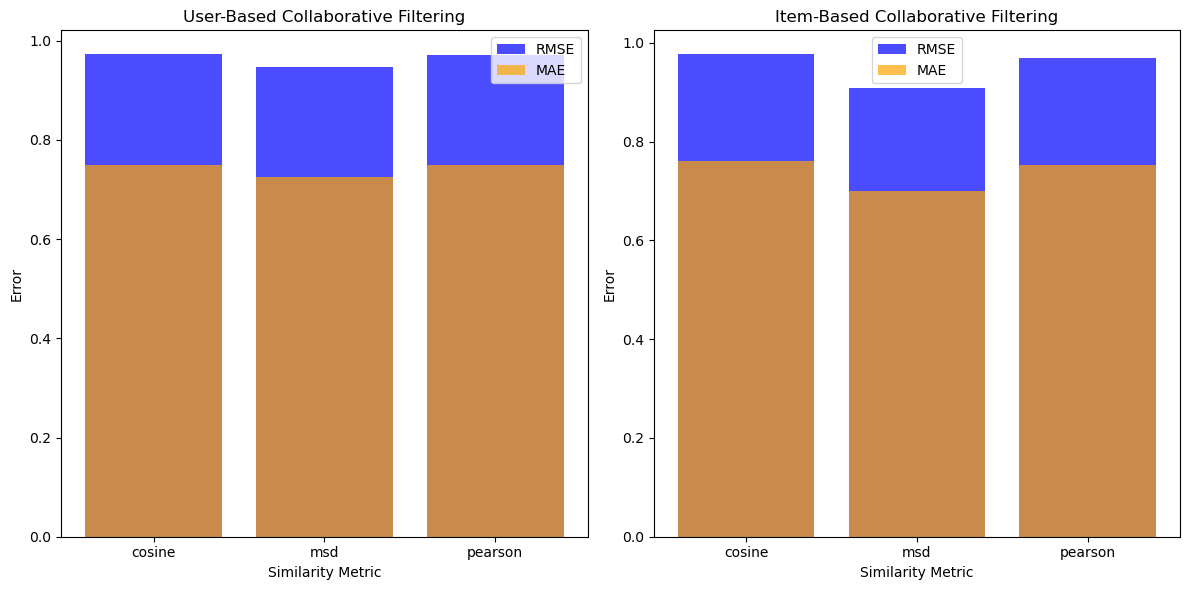

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0204  1.0278  1.0157  1.0095  1.0127  1.0172  0.0064  
MAE (testset)     0.7882  0.7880  0.7794  0.7780  0.7780  0.7823  0.0047  
Fit time          0.32    0.37    0.34    0.36    0.33    0.34    0.02    
Test time         0.86    0.92    0.66    0.81    0.67    0.78    0.10    
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity ma

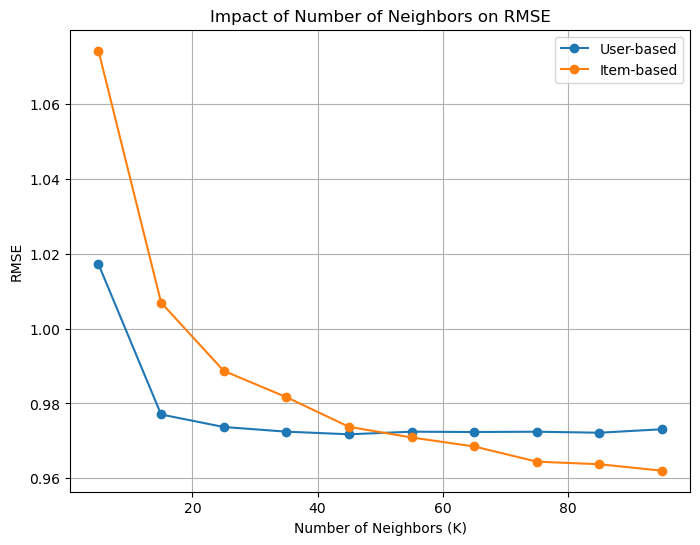


Best K for User-based Collaborative Filtering: 45
Best K for Item-based Collaborative Filtering: 95


In [2]:
import pandas as pd
from surprise import Dataset, Reader, SVD, KNNBasic
from surprise.model_selection import cross_validate, KFold
import matplotlib.pyplot as plt

dataset_path = "ratings.csv"

# Load the dataset
reader = Reader(line_format="user item rating timestamp", sep=",", skip_lines=1)
data = Dataset.load_from_file(dataset_path, reader=reader)

kf = KFold(n_splits=5)

def evaluate_model(algo, data, kf):
    results = cross_validate(algo, data, measures=["RMSE", "MAE"], cv=kf, verbose=True)
    rmse_mean = results["test_rmse"].mean()
    mae_mean = results["test_mae"].mean()
    return results, rmse_mean, mae_mean

pmf = SVD()
pmf_results, pmf_rmse, pmf_mae = evaluate_model(pmf, data, kf)

sim_options_user = {"name": "cosine", "user_based": True}
user_cf = KNNBasic(sim_options=sim_options_user)
user_results, user_rmse, user_mae = evaluate_model(user_cf, data, kf)

sim_options_item = {"name": "cosine", "user_based": False}
item_cf = KNNBasic(sim_options=sim_options_item)
item_results, item_rmse, item_mae = evaluate_model(item_cf, data, kf)

# Display Results
print("\n--- Results ---")
print("PMF -> RMSE:", pmf_rmse, ", MAE:", pmf_mae)
print("User-based -> RMSE:", user_rmse, ", MAE:", user_mae)
print("Item-based -> RMSE:", item_rmse, ", MAE:", item_mae)

# Comparison
print("\nItem-based collaborative filtering is the best in the movie rating data.") if item_rmse < user_rmse and item_rmse < pmf_rmse else print("Another method is better.")

metrics = ["cosine", "msd", "pearson"]
results_user = {}
results_item = {}

for metric in metrics:
    # User-based
    sim_options_user = {"name": metric, "user_based": True}
    algo = KNNBasic(sim_options=sim_options_user)
    _, rmse, mae = evaluate_model(algo, data, kf)
    results_user[metric] = (rmse, mae)

    # Item-based
    sim_options_item = {"name": metric, "user_based": False}
    algo = KNNBasic(sim_options=sim_options_item)
    _, rmse, mae = evaluate_model(algo, data, kf)
    results_item[metric] = (rmse, mae)

# Plot results for comparison
x = range(len(metrics))
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(x, [results_user[m][0] for m in metrics], color="blue", alpha=0.7, label="RMSE")
plt.bar(x, [results_user[m][1] for m in metrics], color="orange", alpha=0.7, label="MAE")
plt.xticks(x, metrics)
plt.title("User-Based Collaborative Filtering")
plt.xlabel("Similarity Metric")
plt.ylabel("Error")
plt.legend()

plt.subplot(1, 2, 2)
plt.bar(x, [results_item[m][0] for m in metrics], color="blue", alpha=0.7, label="RMSE")
plt.bar(x, [results_item[m][1] for m in metrics], color="orange", alpha=0.7, label="MAE")
plt.xticks(x, metrics)
plt.title("Item-Based Collaborative Filtering")
plt.xlabel("Similarity Metric")
plt.ylabel("Error")
plt.legend()

plt.tight_layout()
plt.show()

neighbors = list(range(5, 105, 10))
user_rmse_neighbors = []
item_rmse_neighbors = []

for k in neighbors:
    # User-based
    sim_options_user = {"name": "cosine", "user_based": True}
    algo = KNNBasic(k=k, sim_options=sim_options_user)
    _, rmse, _ = evaluate_model(algo, data, kf)
    user_rmse_neighbors.append(rmse)

    # Item-based
    sim_options_item = {"name": "cosine", "user_based": False}
    algo = KNNBasic(k=k, sim_options=sim_options_item)
    _, rmse, _ = evaluate_model(algo, data, kf)
    item_rmse_neighbors.append(rmse)

# Plot neighbors vs RMSE
plt.figure(figsize=(8, 6))
plt.plot(neighbors, user_rmse_neighbors, label="User-based", marker="o")
plt.plot(neighbors, item_rmse_neighbors, label="Item-based", marker="o")
plt.title("Impact of Number of Neighbors on RMSE")
plt.xlabel("Number of Neighbors (K)")
plt.ylabel("RMSE")
plt.legend()
plt.grid()
plt.show()


# Best K for User-based and Item-based
best_k_user = neighbors[user_rmse_neighbors.index(min(user_rmse_neighbors))]
best_k_item = neighbors[item_rmse_neighbors.index(min(item_rmse_neighbors))]
print("\nBest K for User-based Collaborative Filtering:", best_k_user)
print("Best K for Item-based Collaborative Filtering:", best_k_item)
